In [1]:
import foolbox
import PIL.Image as Image

import matplotlib.pyplot as plt
import keras
import numpy as np
from keras.applications.resnet50 import ResNet50

from vector_fields import draw_vector_field

from keras.applications.resnet50 import ResNet50

# instantiate model
keras.backend.set_learning_phase(0)
kmodel = ResNet50(weights='imagenet')
preprocessing = (np.array([104, 116, 123]), 1)
#preprocessing = (np.array([104, 116, 123]), np.array([57.375, 57.12 , 58.395]))
fmodel = foolbox.models.KerasModel(kmodel, bounds=(0, 255), preprocessing=preprocessing)

# get source image and label
image, label = foolbox.utils.imagenet_example()

# ADef config
candidates = 1          # The only candidate is the one with the second highest score
max_iter = 100          # Maximum number of iterations
max_norm = np.inf       # Maximum norm of the vector field
sigma = 1               # Parameter for the smoothing of the vector field
overshoot = 1.3         # Parameter to handle situations when the image is on the decision boundary 
                        #  between the correct class and the target class
targeting = False       # Stop as soon as model is misclassified
verbose = True       # If True: Print progress


attack = foolbox.attacks.ADefAttack(fmodel)
adversarial = attack(image[:, :, ::-1], label, ind_of_candidates=candidates, max_norm=max_norm, 
                     max_iter=max_iter, smooth=sigma, overshoot=overshoot, targeting=targeting,
                     verbose=verbose)
                  
vector_field = attack.vector_field


/home/rusak_local/venv/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Iterations finished: 0
	Current labels: [282]
Iterations finished: 1
	Current label: [282]
	norm(tau) = 1.9606277209788652
Iterations finished: 2
	Current label: [282]
	norm(tau) = 2.4270354293393406
Iterations finished: 3
	Current label: [282]
	norm(tau) = 2.4791040811464784
Iterations finished: 4
	Current label: [282]
	norm(tau) = 2.484581360102946
Iterations finished: 5
	Current label: [282]
	norm(tau) = 2.485174331962769
Iterations finished: 6
	Current label: [282]
	norm(tau) = 2.485228190662848
Iterations finished: 7
	Current label: [282]
	norm(tau) = 2.485233086937666
Image successfully deformed from 282 to 281.
Iterations finished: 8
	Current label: [281]
	norm(tau) = 2.4852379832199873


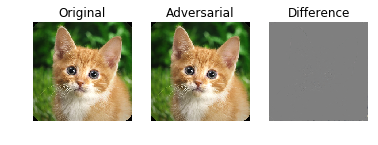

In [2]:
plt.figure()

original_title = 'Original'
plt.subplot(1, 3, 1)
plt.title(original_title)
plt.imshow(image / 255)  # division by 255 to convert [0, 255] to [0, 1]
plt.axis('off')

adv_title = 'Adversarial'
plt.subplot(1, 3, 2)
plt.title(adv_title)
plt.imshow(adversarial[:, :, ::-1] / 255)  # ::-1 to convert BGR to RGB
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Difference')
difference = adversarial[:, :, ::-1]- image
plt.imshow(difference / abs(difference).max() * 0.2 + 0.5)
plt.axis('off')

plt.show()

In [3]:
pertl2 = np.linalg.norm( image.ravel()/255.0 - (adversarial[:, :, ::-1] / 255).ravel(), ord=2 )
pertlinf = np.linalg.norm( image.ravel()/255.0 - (adversarial[:, :, ::-1] / 255).ravel(), ord=np.inf )
# Size of vector field:
vecnorms = np.sqrt( vector_field[:,:,0]**2 + vector_field[:,:,1]**2 )
vfl2 = np.linalg.norm( vecnorms.ravel(), ord=2 )
vfT = np.linalg.norm( vecnorms.ravel(), ord=np.inf )

Drawing 10433 arrows


Text(0.5,0,'$\\ell^2$-norm: 0.844,  $\\ell^\\infty$-norm: 0.092')

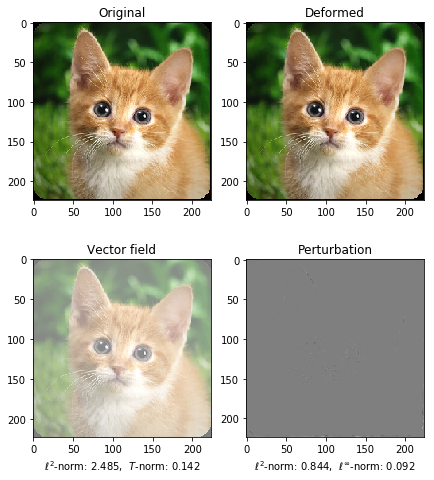

In [4]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2)
fig.set_size_inches(7,8)

ax1.imshow( image/255 )
ax2.imshow( adversarial[:, :, ::-1] / 255 )
bg_image = adversarial[:, :, ::-1] //2 + 128
ax3.imshow( bg_image.astype(int) )
draw_vector_field( ax3, vector_field, amp=4, tol=0.01 )
difference = adversarial[:, :, ::-1] - image
ax4.imshow(difference / abs(difference).max() * 0.2 + 0.5) 

ax1.set_title( 'Original' )
ax2.set_title( 'Deformed' )
ax3.set_title( 'Vector field' )
ax4.set_title( 'Perturbation' )

ax3.set_xlabel(r'$\ell^2$-norm: %.3f,  $T$-norm: %.3f' %( vfl2, vfT ) )
ax4.set_xlabel(r'$\ell^2$-norm: %.3f,  $\ell^\infty$-norm: %.3f' %( pertl2, pertlinf ) )